In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import seaborn as sns
import tensorflow_hub as hub
from tensorflow.keras import models, layers

In [1]:
# unzip the dataset

import zipfile

with zipfile.ZipFile("New Plant Diseases Dataset(Augmented).zip","r") as zip_ref:

    zip_ref.extractall("")

# import the necessary packages


In [57]:
import os
path="./data/New Plant Diseases Dataset(Augmented)/train/"
# walk through  the pizza_steak
total=0
for dirpath,dirnames,filenames in os.walk(path):
  total+=len(filenames)
  print(f"there are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

print("Total no of file to test and Train is "+str(total))

there are 15 directories and 1 files in ./data/New Plant Diseases Dataset(Augmented)/train/
there are 0 directories and 1913 files in ./data/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___Bacterial_spot
there are 0 directories and 1988 files in ./data/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___healthy
there are 0 directories and 1939 files in ./data/New Plant Diseases Dataset(Augmented)/train/Potato___Early_blight
there are 0 directories and 1824 files in ./data/New Plant Diseases Dataset(Augmented)/train/Potato___healthy
there are 0 directories and 1939 files in ./data/New Plant Diseases Dataset(Augmented)/train/Potato___Late_blight
there are 0 directories and 1702 files in ./data/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot
there are 0 directories and 1920 files in ./data/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight
there are 0 directories and 1926 files in ./data/New Plant Diseases Dataset(Augmented)/train/Tomat

## make csv

In [58]:
import os

class_names=[]

for folder in os.listdir(path):
    if(folder==".DS_Store"):
        continue
    class_names.append(folder)

In [59]:
import os

 

df_data={}


for class_name in class_names:
    # get all the file names
    file_names=os.listdir(path+class_name)
    df_data[class_name]=file_names

    


In [ ]:
# make dataset for full data set
import pandas as pd
df = pd.DataFrame(columns=['id', 'leaf_family','file_path'])


for key in df_data:
    print(f"{key}>> ",len(df_data[key]))
    for i in range(len(df_data[key])):
        id=df_data[key][i][:-4]
        leaf_family=key
        file_path=path+key+'/'+df_data[key][i]

        df = df.append({'id': id, 'leaf_family': leaf_family, 'file_path': file_path}, ignore_index=True)

# df.to_csv("./data/PlantVillage/PlantVillage.csv",index=False)

    #     # df = df.append({'id': df_data[key][i][:-4], 'leaf_family': key, 'file_path': "./data/PlantVillage/"+key+'/'+df_data[key][i]}, ignore_index=True)
    #     print(df_data[key][i][:-4],key,"./data/PlantVillage/"+key+'/'+df_data[key][i])




In [61]:
# save

df.to_csv("newLeafDisease.csv",index=False)

In [10]:
# shuffle the dataset

plant_df=pd.read_csv("newLeafDisease.csv")

plant_df=plant_df.sample(frac=1).reset_index(drop=True)

In [12]:
labels=plant_df['leaf_family'].to_numpy()

# find the unique labels
unique_labels=np.unique(labels)
print(unique_labels)

['Pepper,_bell___Bacterial_spot' 'Pepper,_bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [15]:
# now Turn all label

boolean_labels=[label==unique_labels for label in labels]

file_paths=plant_df["file_path"]

In [16]:
X=file_paths
y=boolean_labels

In [17]:
# define the image size
IMG_SIZE=224

# lets createthe function to process the image

def process_image(image_path,img_size=IMG_SIZE):
   """
  Takes an image file path and turns the image into a tensor
  """

   # read the iamge file
   image_file=tf.io.read_file(image_path)

   # Turn jpeg image into numerical tensor with 3 colours channels (Red,blue,Green)

   image=tf.image.decode_jpeg(image_file,channels=3)

   # Normalize the value from 0-255 to 0-1
   image=tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image
   image=tf.image.resize(image,size=[img_size,img_size])

   return image

In [18]:
# create a function to return a tuple(image,label)

def get_image_label(image_path,label):

    """
    Take an image file path name and the associated label
    process the image with the `process image function`
    """
    image=process_image(image_path)
    return image,label

In [19]:
# lets Batch size
BATCH_SIZE = 32

def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    This Function Turn the data into image (x) and label (y) paris

    shuffles the data if it's training data but not for validation data

    also accepts test data as input (no labels)
    """

    # for Test Data
    if test_data:
        print("Making the test data batch 🧑‍🍳")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only file path (no labels)

        data_batches=data.map(process_image).batch(BATCH_SIZE)

        return data_batches

    # for Validation Data
    elif valid_data:
        print("Making the Validation data batch 🧑‍🍳")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # file path
                                                    tf.constant(y)))
        data_batches=data.map(get_image_label).batch(BATCH_SIZE)

        return data_batches
    else:
        print ("Making the Training data batch 🧑‍🍳")

        # Turn file path and labels into data batches
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # file path
                                                    tf.constant(y)))
        # Shuffling path and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image,label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batches = data.batch(BATCH_SIZE)

        return data_batches


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [21]:
# create train and valid data batches

train_data=create_data_batches(x=x_train,y=y_train)

val_data=create_data_batches(x_test,y_test,valid_data=True)


Making the Training data batch 🧑‍🍳
Making the Validation data batch 🧑‍🍳


In [22]:
import matplotlib.pyplot as plt

def show_25_image(images,labels):
    """
    This function is used to show 25 images with labels
    """
    # define the plt size
    plt.figure(figsize=(15,15))
    # loop 25 times
    for i in range(25):
        # define the subplot
        ax=plt.subplot(5,5,i+1) # 5*5=25
        # turn off the grid
        ax.grid(False)
        # turn off the axis
        plt.axis('off')

        # get the image
        img=images[i]
        # get the label
        label=unique_labels[labels[i].argmax()]
        """
            lables=[0,0,0,0,0,1,0]
            here argmax() -> give idx of i which is the breed name idx
        """
        # show the image
        plt.imshow(img)
        # set the title
        plt.title(label)




2023-11-16 19:32:51.473041: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


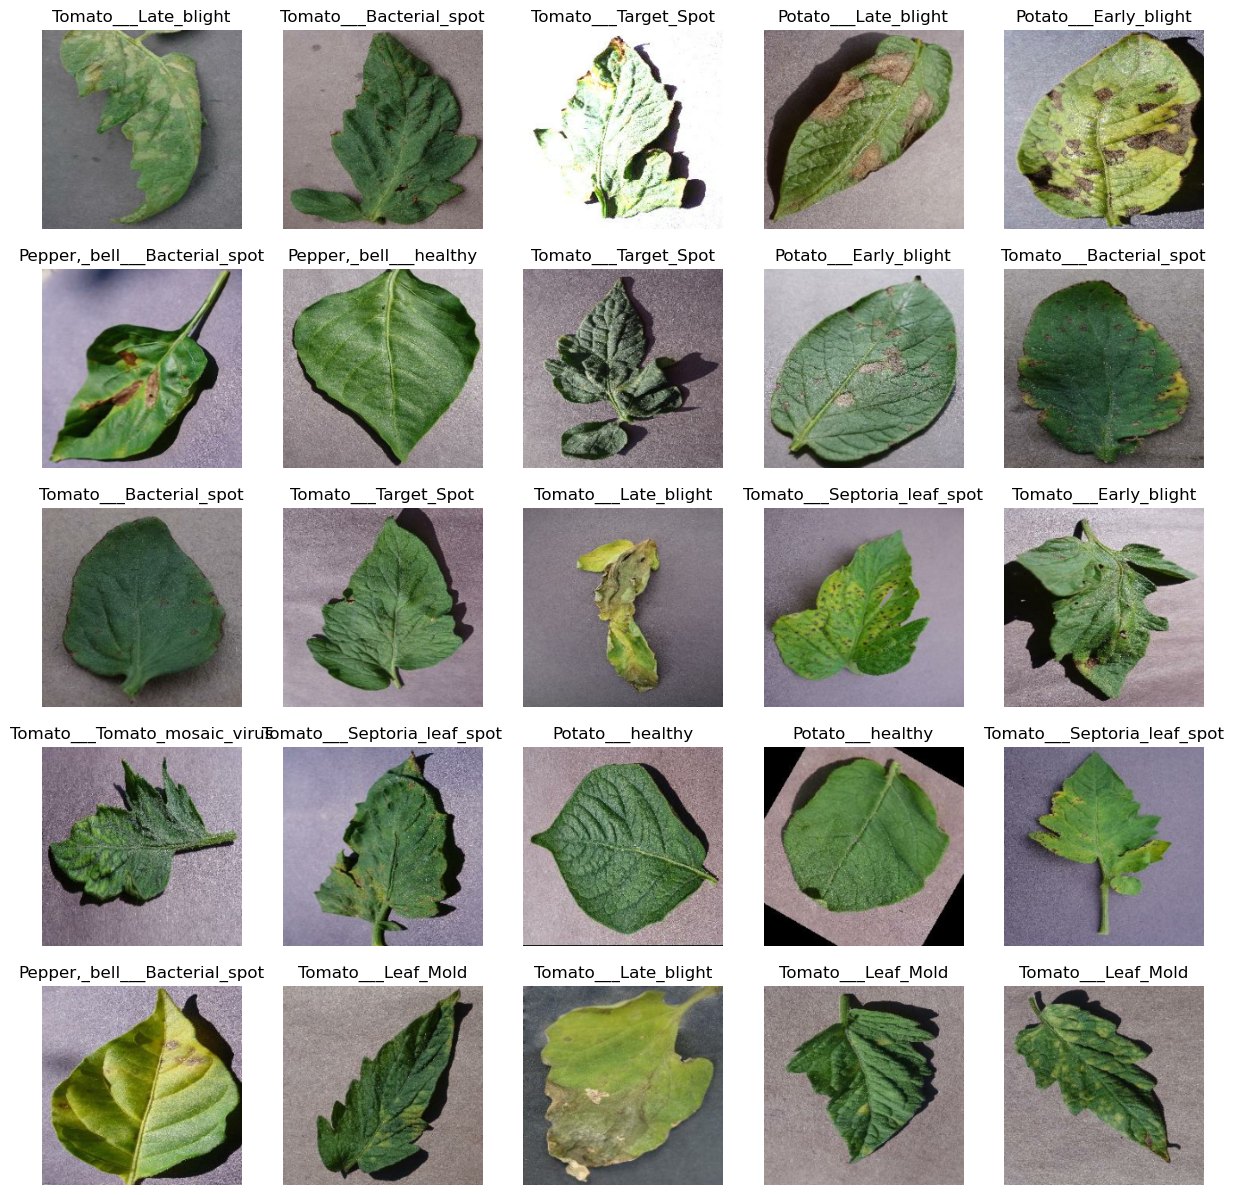

In [23]:
# unbatch our train data using next()

train_images,train_labels=next(train_data.as_numpy_iterator())

show_25_image(train_images, train_labels)



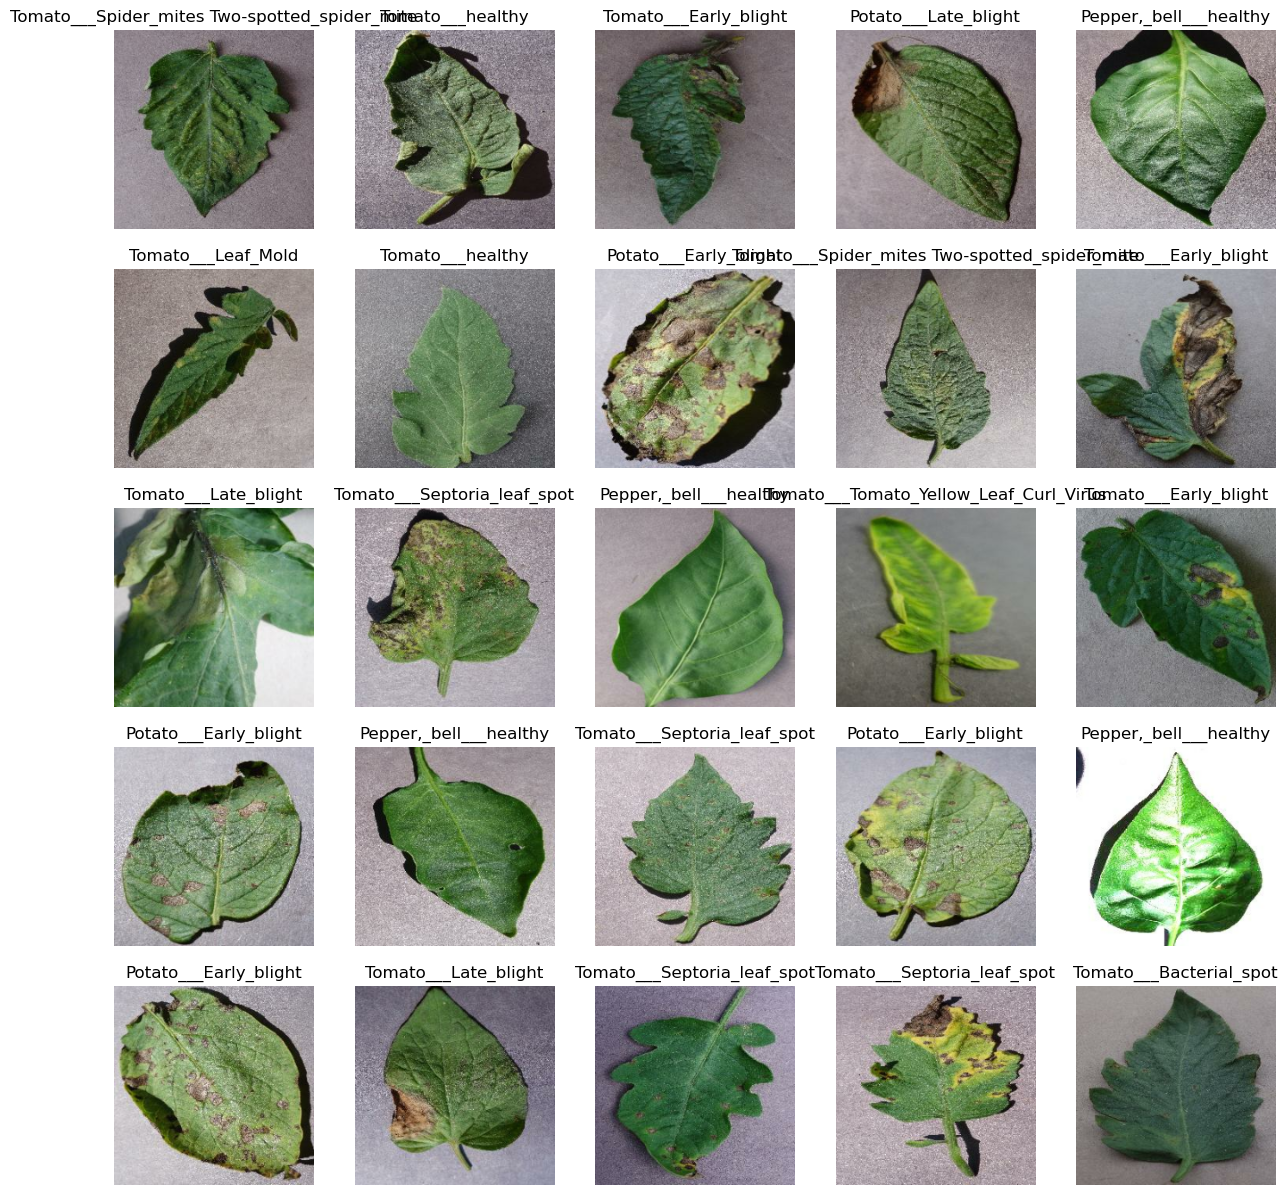

In [74]:
# lets do same for validation set

val_image,val_labels=next(val_data.as_numpy_iterator())

show_25_image(val_image,val_labels)

### Build the deep learning model

**2. CNN Architecture**

![image](https://miro.medium.com/v2/resize:fit:640/format:webp/1*5iA55983nBMlQn9f6ICxKg.png)


In [84]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # batch , height,width,color

# setup output shape of our model
OUTPUT_SHAPE = len(unique_labels)

# model url from Tenserflow hub
MODEL_URL ="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


In [85]:
# create a function to build the model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model 🏗️ ",input_shape,output_shape,model_url)
  with tf.device('/device:GPU:0'):
  # 1 .create the model
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer)
        tf.keras.layers.Dense(
            units=OUTPUT_SHAPE,
            activation="softmax"  # layer 2 (output layer)
        )
    ])

    # 2.compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.legacy.Adam(),
        metrics=["accuracy"]
    )

    # 3.build the model
    model.build(input_shape)

  return model


In [86]:
model1=create_model()

Building the model 🏗️  [None, 224, 224, 3] 15 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [87]:
NUM_EPOCHS=100 #@param {types:"sliders",min:10,max:100, step:10}

# create a function to stop

early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=25# no of epocs
                                                )

In [88]:
# Build a function to train adn return a trained model

def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # create a model

  model = create_model()

  # create a new TensorBaord session everytime we train a model
  # tensorbaord=create_tensorboard_callback()

  # fit the model to the date passing it the callbacks we created

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[early_stopping]
            )

  # return the model

  return model

In [89]:
# fit the model to the data

model=train_model()

Building the model 🏗️  [None, 224, 224, 3] 15 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
699/699 [==============================] - 355s 505ms/step - loss: 0.4977 - accuracy: 0.8458 - val_loss: 0.2957 - val_accuracy: 0.9009
Epoch 2/100
699/699 [==============================] - 361s 516ms/step - loss: 0.2227 - accuracy: 0.9284 - val_loss: 0.2114 - val_accuracy: 0.9322
Epoch 3/100
699/699 [==============================] - 360s 514ms/step - loss: 0.1759 - accuracy: 0.9415 - val_loss: 0.1940 - val_accuracy: 0.9349
Epoch 4/100
699/699 [==============================] - 357s 510ms/step - loss: 0.1519 - accuracy: 0.9493 - val_loss: 0.1775 - val_accuracy: 0.9417
Epoch 5/100
699/699 [==============================] - 355s 508ms/step - loss: 0.1323 - accuracy: 0.9560 - val_loss: 0.1942 - val_accuracy: 0.9340
Epoch 6/100
699/699 [==============================] - 357s 511ms/step - loss: 0.1200 - accuracy: 0.9603 - val_loss: 0.1762 - val_accuracy: 0.9420


In [5]:
model=load_model("/Volumes/Project-2/programming/machine_deep_learning/DL/models/20231008-22141696783457-21k-images-mobilenetv2-Adam.h5")


Loading saved model from: /Volumes/Project-2/programming/machine_deep_learning/DL/models/20231008-22141696783457-21k-images-mobilenetv2-Adam.h5


In [24]:
model.evaluate(val_data)

175/175 [==============================] - 101s 567ms/step - loss: 0.0549 - accuracy: 0.9880


[0.054867636412382126, 0.9880143404006958]

In [32]:
predictions=model.predict(val_data,verbose=1)

175/175 [==============================] - 70s 395ms/step


In [33]:
predictions[0].argmax()

3

In [25]:
# Turn our numerical prediction - Text lbel

def get_prediction_label(pred_proba):
  """
  Turns an array of prediction probilities into a lable
  """
  return unique_labels[pred_proba.argmax()]



In [121]:

def unbatchify(data, no_of_batches=1):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels for a specified number of batches.
    """
    images = []
    labels = []
    batch_size=BATCH_SIZE * no_of_batches

    # un-batch it
    for batch_index, (image, label) in enumerate(data.unbatch().as_numpy_iterator()):
        images.append(image)
        labels.append(unique_labels[label.argmax()])

        # Check if the desired number of batches is reached
        if batch_index + 1 == batch_size:
            break

    return images, labels

# Example: Unbatchify the validation data for the first 3 batches
val_images, val_labels = unbatchify(val_data, no_of_batches=100)

In [91]:
len(val_images)

3200

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(prediction_prob, images, labels, n=1):
    """
    View the prediction, ground truth, and image for n samples.
    """

    pred_prob, true_label, image = prediction_prob[n], labels[n], images[n]
    pred_label = get_prediction_label(pred_prob)
    print(pred_prob)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f'Ground Truth: {unique_labels[np.argmax(true_label)]} with accuracy of {pred_prob[pred_prob.argmax()] *100} %')

    # Display the top 5 prediction probabilities as a bar chart
    top5_indices = np.argsort(pred_prob)[::-1][:5]
    top5_labels = [unique_labels[i] for i in top5_indices]
    top5_probs = pred_prob[top5_indices]
    ax2.barh(np.arange(5), top5_probs, color='purple')
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(top5_labels, size='small')
    ax2.set_xlim(0, 1.1)
    ax2.set_xlabel('Prediction Probability')
    ax2.set_title('Top 5 Predictions')

    # If correct prediction, change the color of the title to green

    if pred_label == unique_labels[np.argmax(true_label)]:
        ax1.set_title(f'Ground Truth: {unique_labels[np.argmax(true_label)]} with accuracy of {pred_prob[pred_prob.argmax()] *100} %', color='green')

    plt.tight_layout()
    plt.show()





[1.8105823e-27 1.6185425e-21 2.6046271e-17 2.5578247e-08 1.0000000e+00
 5.3536896e-26 1.0418179e-20 6.7282856e-19 2.3502110e-27 6.0874380e-25
 6.3275595e-20 3.7254805e-17 2.5692464e-27 2.6851824e-27 4.8913340e-19]


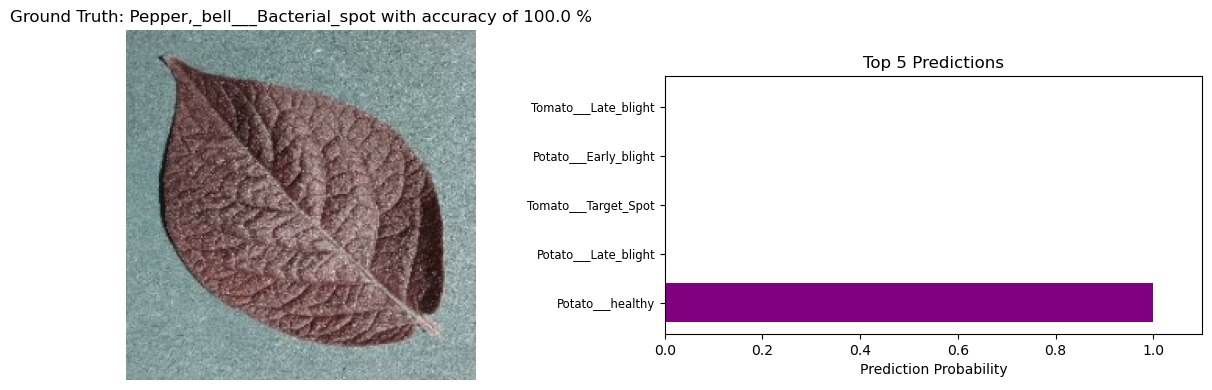

In [82]:
plot_prediction(predictions,labels=val_labels,images=val_images,n=40)

In [83]:
def plot_pred_conf(prediction_probabilities,labels,n=1):

  """
  Plus the top 5 hight predictions confidences along with
  the truth label for n smaple
  """

  pred_prob,true_label=prediction_probabilities[n],labels[n]

  # get the prediction label fomr the function we created

  pred_label=get_prediction_label(pred_prob)


  # Find the predictions confidence indixes

  top_predictions_indexes=pred_prob.argsort()[::-1] # reverse them

  # find the top prediction  value

  top_pred_values=pred_prob[top_predictions_indexes][:5]


  # find the pred label

  top_pred_labels=unique_labels[top_predictions_indexes][:5]

  # set up plot

  top_plots=plt.bar(np.arange(len(top_pred_values)), # x
                    top_pred_values, # y
                    color="grey"
                    )

  plt.xticks(np.arange(len(top_pred_values)),
             labels=top_pred_labels,
             rotation="vertical",
             )

  # chagne the color of true label to green and other to gray

  for i in range(len(top_predictions_indexes)):
    pred=top_pred_labels[i]

    # if equal to true label
    if pred==true_label:

      top_plots[i].set_color("green")

      break

[4.7816244e-24 2.0657293e-29 6.1453871e-20 1.0000000e+00 1.1888625e-14
 1.4837774e-32 2.0769093e-22 7.5196689e-20 1.6707473e-23 3.7684399e-28
 2.5738463e-20 5.6538382e-29 0.0000000e+00 0.0000000e+00 4.4610645e-31]


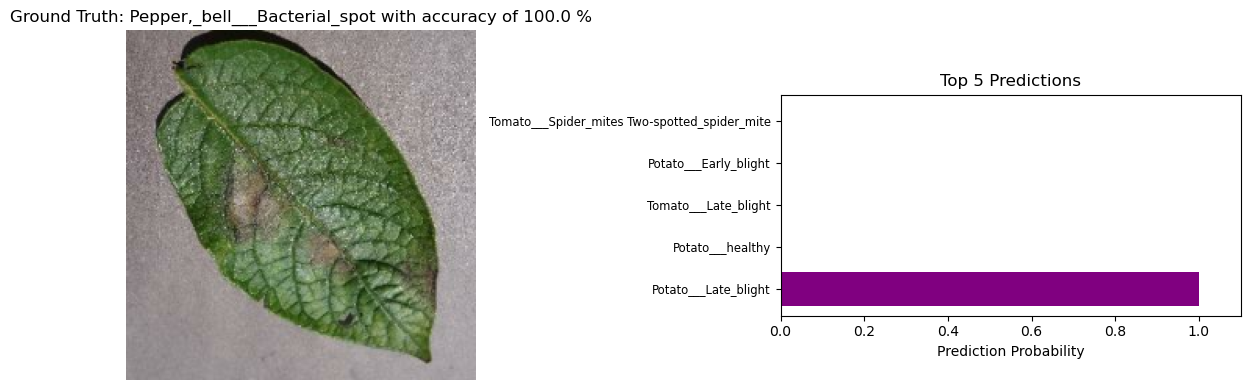

[5.2790667e-17 3.9053941e-15 1.5240167e-22 2.3299721e-15 4.1567352e-13
 4.1768422e-13 1.4464501e-06 1.2573888e-07 1.4230941e-11 3.6151852e-12
 7.9635513e-01 2.0364332e-01 6.1334928e-09 1.3677425e-13 2.7929855e-16]


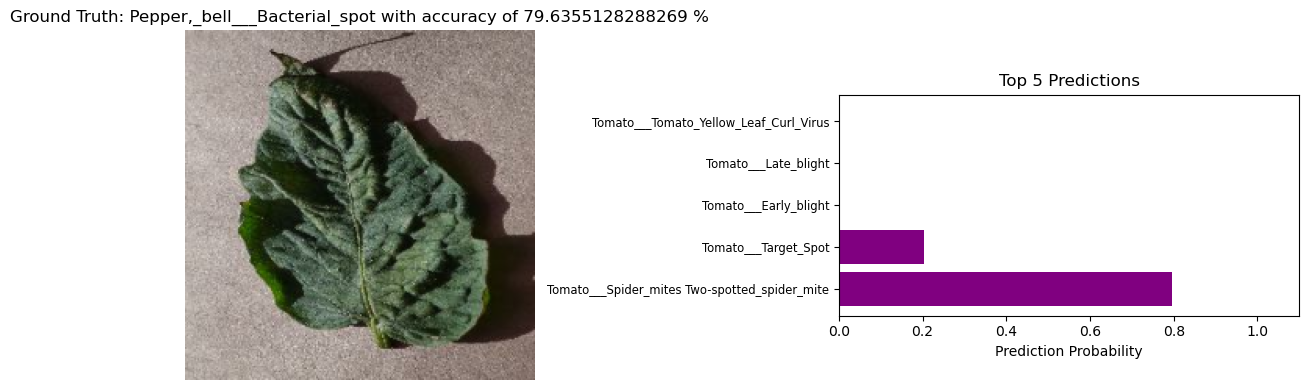

[3.11286641e-08 1.47666810e-07 3.99186463e-23 4.98733776e-10
 2.91163881e-12 3.79991553e-18 7.69527997e-09 1.42871926e-04
 1.90999874e-08 6.66393069e-12 9.88923371e-01 2.61930254e-04
 4.37458438e-11 4.86285039e-20 1.06716715e-02]


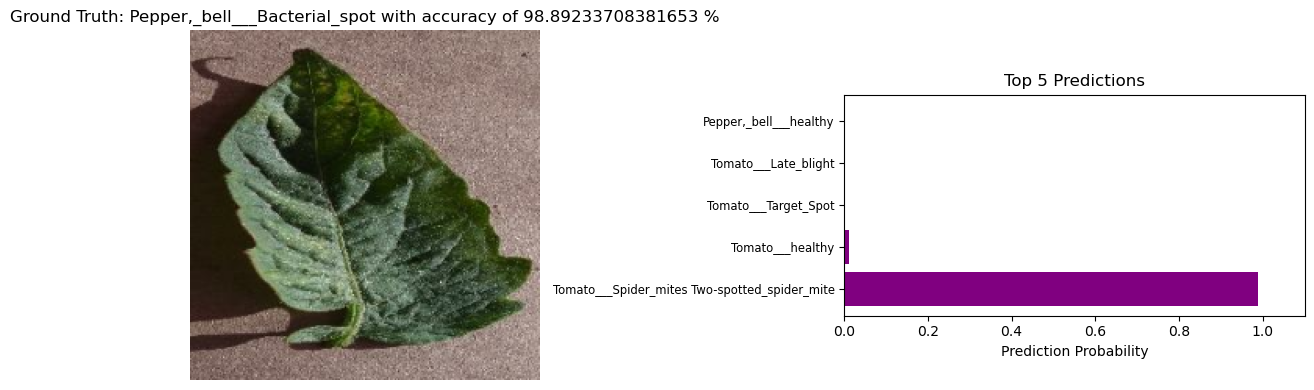

[1.5419857e-15 6.4325662e-23 3.3401703e-27 2.4297553e-15 1.0797974e-17
 4.3179751e-17 7.2617738e-11 1.1687246e-10 1.0000000e+00 1.1677596e-10
 3.6509282e-14 1.0515911e-15 2.1830950e-13 8.1637499e-17 1.0293429e-27]


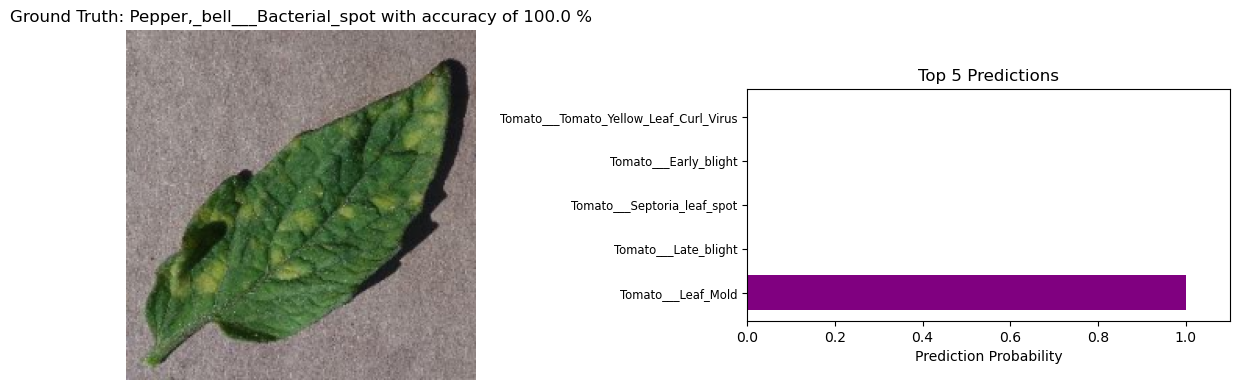

[2.40112536e-24 0.00000000e+00 0.00000000e+00 2.43309205e-17
 4.30050527e-30 1.60441371e-24 5.64948533e-13 6.68599584e-18
 1.00000000e+00 2.26016650e-20 1.95542974e-12 1.19468985e-23
 3.29342391e-17 6.27950951e-22 9.52989686e-35]


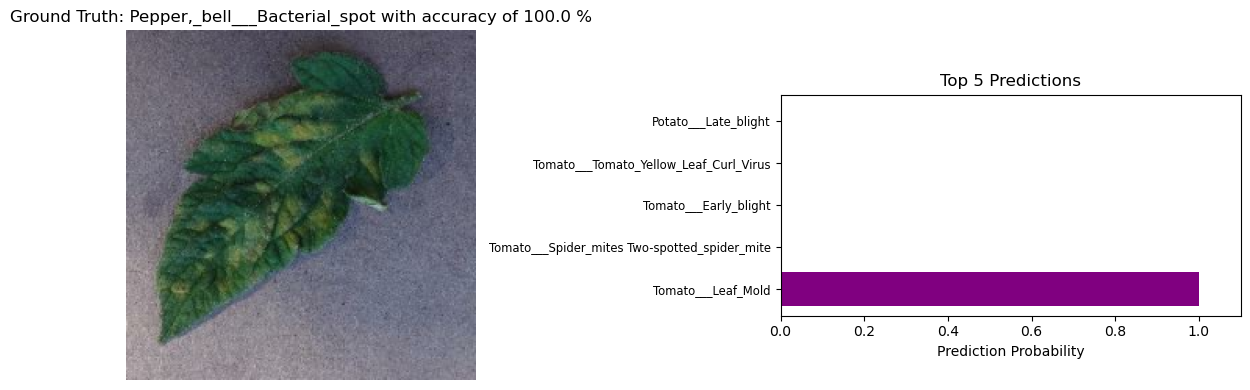

[2.1777727e-04 9.9978226e-01 4.0127063e-28 1.6431534e-20 1.8368047e-16
 9.6300393e-17 1.1055303e-17 1.3829471e-18 4.9820495e-24 1.1816171e-17
 1.6154789e-18 1.9305279e-17 6.9225470e-22 2.3741882e-27 1.9606634e-21]


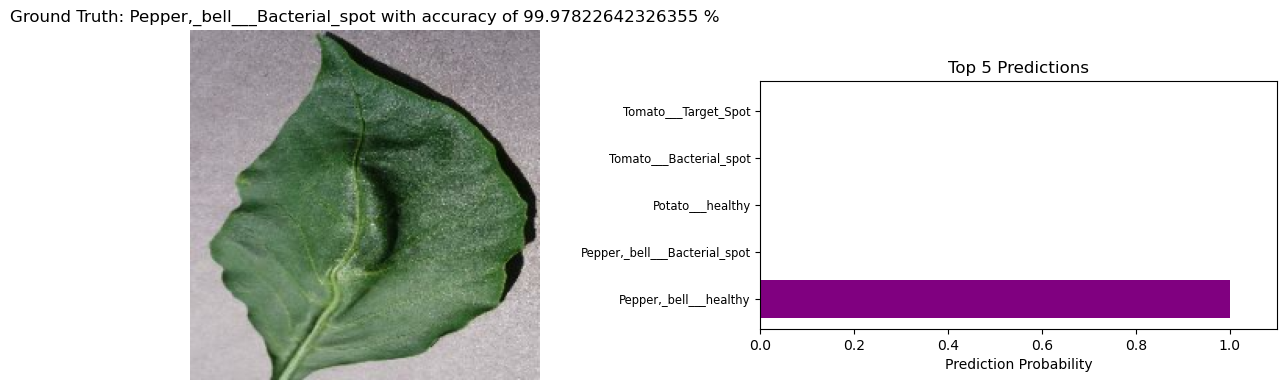

<Figure size 640x480 with 0 Axes>

In [85]:
# Let's check out a few predictions and their different values

# Set the parameters for visualization
i_multiplier = 90
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

# Create a figure with appropriate dimensions
# plt.figure(figsize=(10 * num_cols, 5 * num_rows))

# Iterate through the images and plot predictions and confidence
for i in range(num_images):
    # plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_prediction(predictions, labels=val_labels, images=val_images, n=i + i_multiplier)

    # plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    # plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=i + i_multiplier)

# Adjust layout for better spacing
plt.tight_layout(h_pad=1.0)

# Show the plot
plt.show()


## Evaluation  of the Model

In [131]:
def convert_label_to_int(labels,classes=unique_labels):
    """
    Convert the prediction label to int
    """
    # convert the class to list
    classes=unique_labels.tolist()

    # labels will be in str we have to compare it to the unique label and get the index


    converted_label=tf.constant([ classes.index(label) for label in labels])



    return converted_label

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, title=None):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels
    """

    # Assuming you have calculated the confusion matrix using confusion_matrix function
    cm = confusion_matrix(y_true, y_pred)

    # Check the number of unique classes
    if classes is None:
        classes = range(len(np.unique(y_true)))

    plt.figure(figsize=figsize)

    # Use Seaborn heatmap to plot the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title, fontsize=text_size)

    plt.show()



In [143]:
converted_val_label

<tf.Tensor: shape=(3200,), dtype=int32, numpy=array([ 3, 10,  0, ...,  9, 13,  3], dtype=int32)>

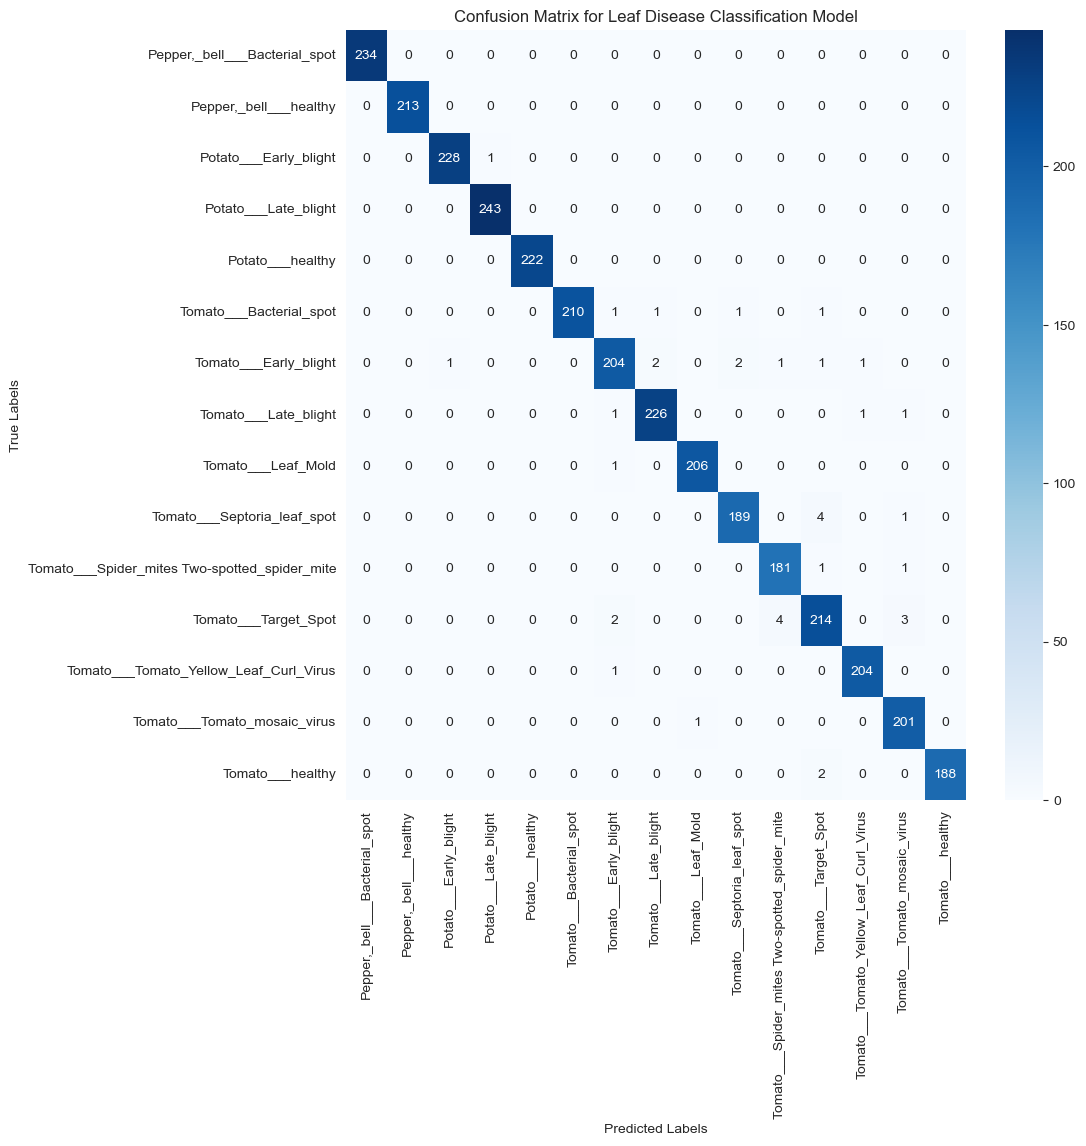

In [144]:

# make prediction on validation data

y_pred_probs=predictions


y_pred=y_pred_probs.argmax(axis=1)

converted_val_label=convert_label_to_int(val_labels) # convert str label to respected idx (int)
# 
val_label_bool=converted_val_label
# create confusion matrix

make_confusion_matrix(y_true=converted_val_label,
                        y_pred=y_pred[:len(converted_val_label)],
                        classes=unique_labels,
                        figsize=(10,10),
                        text_size=12,
                        title="Confusion Matrix for Leaf Disease Classification Model")




## Method to get the Performance metrics such as Accuracy, Precision, Recall, F1 Score

In [145]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def evaluate_model_performance(y_true,y_pred):
    """
    Returns model accuracy, precision, recall and F1 score of a binary classification model.
    """
    # calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # calculate model precision, recall and f1 score using "weighted average method"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision * 100,
                    "recall": model_recall * 100,
                    "f1": model_f1 * 100}
    
    print(f"Accuracy: {model_accuracy:.2f}%")
    print(f"Precision: {model_precision * 100:.2f}%")
    print(f"Recall: {model_recall * 100:.2f}%")
    print(f"F1 Score: {model_f1 * 100:.2f}%")

    
    return model_results

Accuracy: 98.91%
Precision: 98.91%
Recall: 98.91%
F1 Score: 98.91%


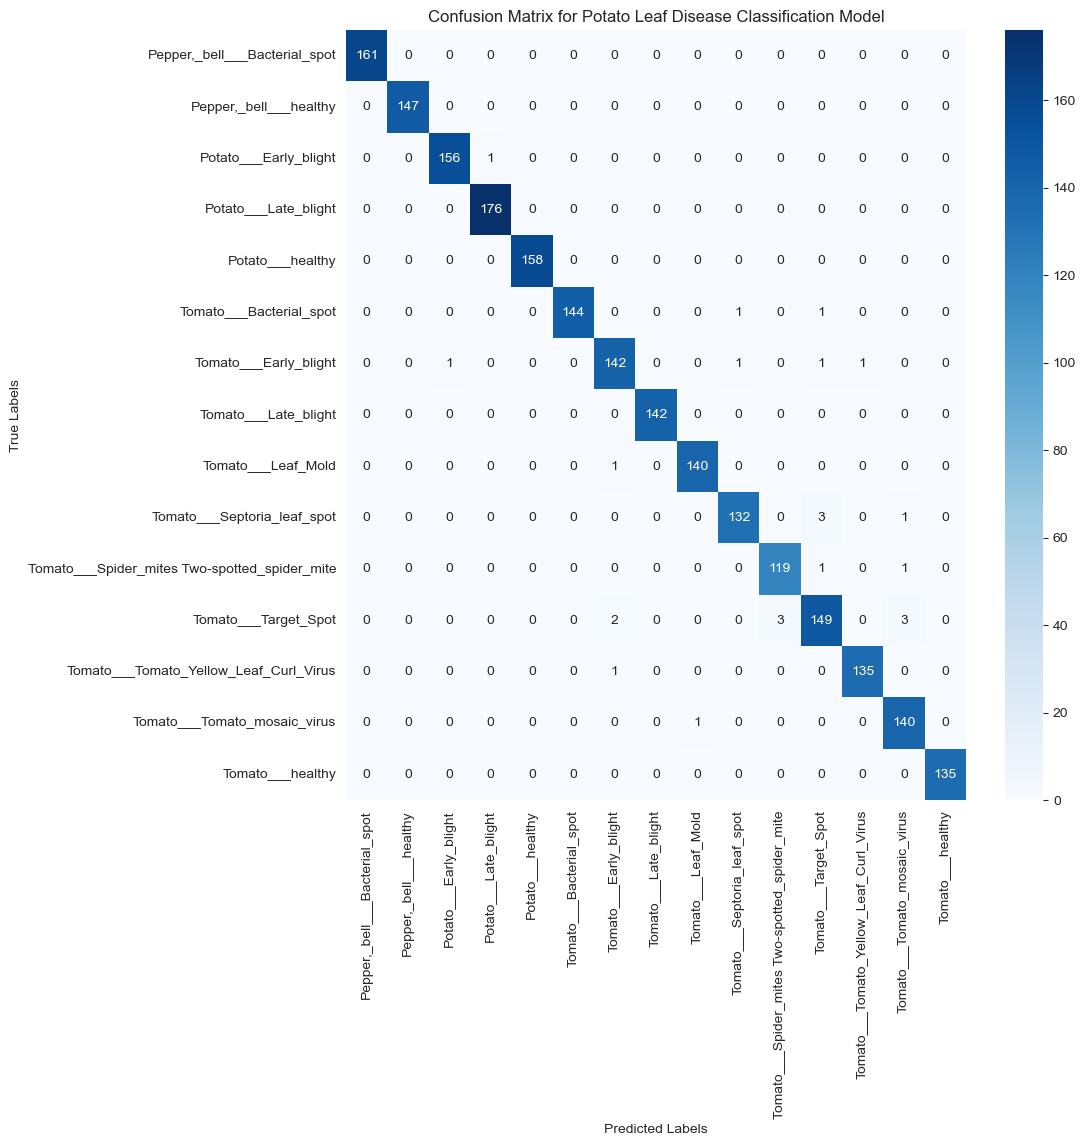

In [153]:

# get the performance metrics

no_of_samples=2200
model_results = evaluate_model_performance(y_true=val_label_bool[:no_of_samples],
                                          y_pred=y_pred[:no_of_samples])
make_confusion_matrix (y_true=val_label_bool[:no_of_samples],
                        y_pred=y_pred[:no_of_samples],
                        classes=unique_labels,
                        figsize=(10,10),
                        text_size=12,
                        title="Confusion Matrix for Potato Leaf Disease Classification Model")


## Saving and reloading a trained model

In [91]:
# Create a function to save a model
import datetime
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("./models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [3]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [94]:
# save the model

save_model(model,suffix="21k-images-mobilenetv2-Adam")

Saving model to: ./models/20231008-22141696783457-21k-images-mobilenetv2-Adam.h5...


'./models/20231008-22141696783457-21k-images-mobilenetv2-Adam.h5'

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 15)                15030     
                                                                 
Total params: 5,447,743
Trainable params: 15,030
Non-trainable params: 5,432,713
_________________________________________________________________
